# PDE-FIND za gušeni klasični harmonijski oscilator

Vinko Dragušica, 2022.

Predstavljen je kod koji pomoću modula PDE-FIND iz danih podataka otkriva jednadžbu koja opisuje dinamiku gušenog klasičnog harmonijskog oscilatora za $\zeta=0.1$.
$$
u_{tt} + 2\zeta u_t + u = 0
$$

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import sys; sys.path.append('../')
from PDE_FIND_CM import *

In [2]:
x = [0]
#dx = x[1]-x[0]
t = np.linspace(0,50,500)
dt = t[1]-t[0]
u = np.zeros((len(x),len(t)))

def wf(x,t):
    zeta = 0.1
    return 5*np.e**(-zeta*t)*np.sin(np.sqrt(1-zeta**2)*t)

for i in range(len(x)):
    for j in range(len(t)):
        u[i,j] = wf(x[i],t[j])

Text(0, 0.5, 'u(t)')

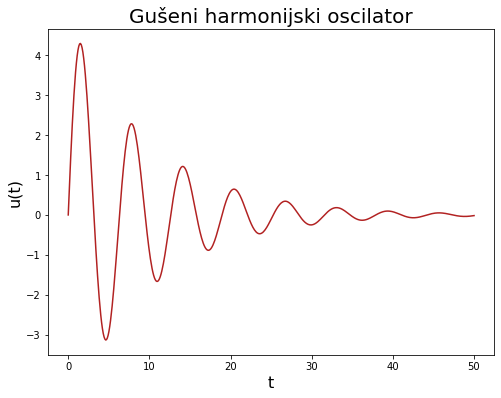

In [3]:
fig1 = plt.figure(figsize=(8,6))
plt.plot(t,u[0,:],color='firebrick')
plt.title('Gušeni harmonijski oscilator', fontsize = 20)
plt.xlabel('t', fontsize = 16)
plt.ylabel('u(t)', fontsize = 16)

## Konstruiramo $\Theta (U)$ i računamo $U_t$:

Konstruiramo funkcije koje će se nalaziti u $\Theta$. Također specificiramo njihove opise i na kraju pomoću build_Theta konstruiramo $\Theta$ koji ćemo koristiti kasnije. <br>
time_diff i space_diff izračunati su pomoću metode konačnih razlika (funkcija FiniteDiff()).

Ispisana je lista funkcija kandidata za PDJ. Svaka od ispisanih funkcija ekvivalentna je stupcu u $\Theta (U)$.

In [4]:
m = len(x)
n = len(t)

ut = np.zeros((m,n), dtype=np.complex64)
utt = np.zeros((m,n), dtype=np.complex64)
sin_t = np.zeros((m,n), dtype=np.complex64)
cos_t = np.zeros((m,n), dtype=np.complex64)
exp_t = np.zeros((m,n), dtype=np.complex64)

for i in range(m):
    ut[i,:] = FiniteDiff(u[i,:], dt, 1)
    utt[i,:] = FiniteDiff(u[i,:], dt, 2) # koristi se kasnije kod funkcije TrainSTRidge
    sin_t[i,:] = np.sin(t)
    cos_t[i,:] = np.cos(t)
    exp_t[i,:] = np.e**t

ut = np.reshape(ut, (n*m,1), order='F')
utt = np.reshape(utt, (n*m,1), order='F')

X_ders = np.hstack([np.ones((n*m,1)), ut])
X_data = np.hstack([np.reshape(u, (n*m,1), order='F'),
                    np.reshape(sin_t, (n*m,1), order='F'),
                    np.reshape(cos_t, (n*m,1), order='F'),
                    np.reshape(exp_t, (n*m,1), order='F')])
derivatives_description = ['','u_t']

X, descr = build_Theta(X_data, X_ders, derivatives_description, P=1, data_description = ['u','sin(t)','cos(t)','e^t'])
descr

['',
 'u_t',
 'e^t',
 'cos(t)',
 'sin(t)',
 'u',
 'e^tu_t',
 'cos(t)u_t',
 'sin(t)u_t',
 'uu_t']

## Računamo $\xi$:

TrainSTRidge dijeli podatke na dio za trening (80% ukupnih podataka) i dio za validaciju (20% ukupnih podataka). Algoritam traži optimalnu vrijednost za varijablu tol (tolerancija ispod koje zanemarujemo varijablu) i odabire toleranciju provjerom na validacijskom skupu, uključujući i $\ell^0$ penalizaciju za $\xi$ u funkciji gubitka.

In [5]:
w = TrainSTRidge(X,utt,10**-5,0.1)
print("PDJ dobivena pomoću STRidge:")
print_pde(w, descr)

PDJ dobivena pomoću STRidge:
u_tt = (-0.200179 +0.000000i)u_t
    + (-0.999128 +0.000000i)u
   


In [6]:
err = abs(np.array([(0.2 -  0.200179)/0.2*100, (1 -  0.999128)*100]))
print("Greška dobivena koristeći PDE-FIND za identifikaciju dinamike na podatcima:\n")
print("Srednja greška parametara:", np.mean(err), '%')
print("Standardna devijacija srednje greške parametara:", np.std(err), '%')

Greška dobivena koristeći PDE-FIND za identifikaciju dinamike na podatcima:

Srednja greška parametara: 0.08834999999999538 %
Standardna devijacija srednje greške parametara: 0.0011499999999969868 %


## Identificiramo istu dinamiku ali sa dodanim šumom na podatcima:

Jedina razlika od primjera gore je da metoda konačnih razlika ne radi dobro za podatke sa šumom pa koristimo polinomijalnu interpolaciju. Sa deg_x ili deg_t i width_x i width_t određujemo stupanj polinoma i broj točaka za deriviranje po x i t. Nažalost, rezultati mogu biti osjetljivi na ove veličine.

In [7]:
np.random.seed(0)
un = u + 0.05*np.std(u)*np.random.randn(u.shape[0],u.shape[1])

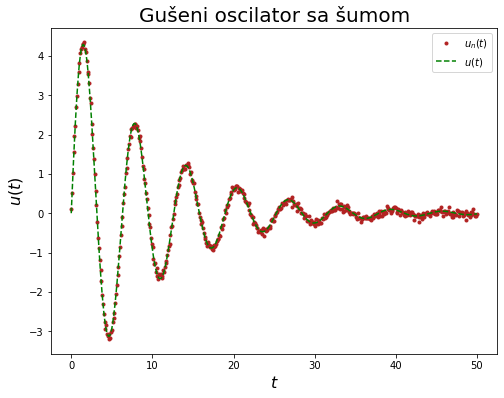

In [8]:
fig1 = plt.figure(figsize=(8,6))
plt.plot(t,un[0,:],'.',color='firebrick',label='$u_n(t)$')
plt.plot(t,u[0,:],'--',color='green',label='$u(t)$')
plt.title('Gušeni oscilator sa šumom', fontsize = 20)
plt.xlabel('$t$', fontsize = 16)
plt.ylabel('$u(t)$', fontsize = 16)
plt.legend()

In [9]:
def trim(u, d): #funkcija koja treba kasnije kako bi algoritam funkcionirao
    ind = np.arange(0, len(u))
    u_trim = np.delete(u, np.concatenate((ind[:d],ind[-d:])))
    return u_trim

In [10]:
m = len(x)
n = len(t)

width = 5 # sirina prozora kod PolyDiff funkcije

unt = np.zeros((m,n-2*width), dtype=np.complex64)
untt = np.zeros((m,n-2*width), dtype=np.complex64)
sin_t = np.zeros((m,n), dtype=np.complex64)
cos_t = np.zeros((m,n), dtype=np.complex64)
exp_t = np.zeros((m,n), dtype=np.complex64)
ones = np.ones((m,n), dtype=np.complex64)

for i in range(m):
    unt[i,:] = PolyDiff(un[i,:], t, diff=2, width=width)[:,0]
    untt[i,:] = PolyDiff(un[i,:], t, diff=2, width=width)[:,1] # koristi se kasnije kod funkcije TrainSTRidge
    sin_t[i,:] = np.sin(t)
    cos_t[i,:] = np.cos(t)
    exp_t[i,:] = np.e**t

un = trim(un[0,:], width)
sin_t = trim(sin_t[0,:], width)
cos_t = trim(cos_t[0,:], width)
exp_t = trim(exp_t[0,:], width)
ones = trim(ones[0,:], width)

unt = np.reshape(unt, (-1,1), order='F')
untt = np.reshape(untt, (-1,1), order='F')

X_ders = np.hstack([np.ones((n*m-2*width,1)), unt])
X_data = np.hstack([np.reshape(un, (-1,1), order='F'),
                    np.reshape(sin_t, (-1,1), order='F'),
                    np.reshape(cos_t, (-1,1), order='F'),
                    np.reshape(exp_t, (-1,1), order='F')])
derivatives_description = ['','u_t']

X, descr = build_Theta(X_data, X_ders, derivatives_description, P=1, data_description = ['u','sin(t)','cos(t)','e^t'])
descr

['',
 'u_t',
 'e^t',
 'cos(t)',
 'sin(t)',
 'u',
 'e^tu_t',
 'cos(t)u_t',
 'sin(t)u_t',
 'uu_t']

In [11]:
w = TrainSTRidge(X,untt,10**-5,0.1)
print("PDJ dobivena pomoću STRidge:")
print_pde(w, descr)

PDJ dobivena pomoću STRidge:
u_tt = (-0.188022 +0.000000i)u_t
    + (-0.978142 +0.000000i)u
   


In [12]:
err = abs(np.array([(0.2 - 0.188022)/0.2*100, (1 - 0.978142)*100]))
print("Greška dobivena koristeći PDE-FIND za identifikaciju dinamike na podatcima sa šumom:\n")
print(np.mean(err), '%')
print("Srednja greška parametara:", np.mean(err), '%')
print("Standardna devijacija srednje greške parametara:", np.std(err), '%')

Greška dobivena koristeći PDE-FIND za identifikaciju dinamike na podatcima sa šumom:

4.087400000000006 %
Srednja greška parametara: 4.087400000000006 %
Standardna devijacija srednje greške parametara: 1.9016000000000017 %
